In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from typing import Tuple
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

from collections import Counter
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

from sklearn.feature_selection import mutual_info_classif

from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier, BaggingClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import matplotlib.patches as mpatches

In [101]:
# load the data from the csv file
df = pd.read_csv('customerGroups.csv')
df.head()

,g1_1,g1_2,g1_3,g1_4,g1_5,g1_6,g1_7,g1_8,g1_9,g1_10,...,c_20,c_21,c_22,c_23,c_24,c_25,c_26,c_27,c_28,target
0,4.50,1,3,4,5,1,1,4,6,0,...,-0.383704,-0.065449,0.584000,0.488000,0,-3.232000,-1.944000,-0.007944,1.76,2
1,2.20,24,22,46,10,24,28,18,22,-4,...,-0.346839,-0.159744,-0.947614,0.463540,0,-5.342174,-1.321355,0.181064,1.85,1
2,12.00,7,4,11,18,8,11,2,10,-3,...,-2.673934,-1.592303,0.525305,-0.467169,0,-6.566521,-4.176403,-0.040277,2.05,2
3,1.91,8,5,13,14,6,7,6,9,-1,...,0.616027,0.404945,-1.506923,0.741964,0,-2.438120,-0.787132,-0.012101,1.82,0
4,2.50,23,16,39,14,33,25,18,27,8,...,-1.057214,-1.159294,0.751012,-0.182052,0,-1.259728,0.059574,0.042613,1.99,2


In [102]:
df.shape

(6620, 71)

We have dataset with 71 columns and 6620 rows. The last column is the target variable which answers the question: 

*"Which customer group was the most profitable, if any?"*.

We would try to answer this question using the provided data. We would also try to find out which features are the most important for the target variable. But first, we would try to predict the values which was recorded after the campaigns started based on the data which was recorded before the campaigns started.


In [181]:
# Check for missing values
df.isnull().sum()

g1_1      0
g1_2      0
g1_3      0
g1_4      0
g1_5      0
         ..
c_25      0
c_26      0
c_27      0
c_28      0
target    0
Length: 71, dtype: int64

## Regression problem: are we able to predict the value known after the campaign was run based on the information known before the start of the campaign?

#### The first group of clients

Column names starting with “g1_”: 
* contain information about the first customer group, 
* variables g1_1 until g1_20 were known before the campaign was run,
* variable g1_21 was recorded after the campaign was run.

In [103]:
# g1_1 to g1_20 are the features
# g1_21 is the target variable
X_g1 = df.iloc[:, :20]
X_g1.head()

,g1_1,g1_2,g1_3,g1_4,g1_5,g1_6,g1_7,g1_8,g1_9,g1_10,g1_11,g1_12,g1_13,g1_14,g1_15,g1_16,g1_17,g1_18,g1_19,g1_20
0,4.50,1,3,4,5,1,1,4,6,0,-2,-2,2.505032,2.551406,6.240000,3.608000,0.744000,1.216000,0.003078,0.003028
1,2.20,24,22,46,10,24,28,18,22,-4,-4,-8,3.718983,3.882271,7.423435,5.048030,0.836178,1.975244,0.784882,0.019448
2,12.00,7,4,11,18,8,11,2,10,-3,-8,-11,2.244550,2.458087,11.091399,5.853005,0.730046,2.022004,0.043937,0.014264
3,1.91,8,5,13,14,6,7,6,9,-1,-3,-4,2.580190,2.683092,9.864426,2.582357,0.656638,1.407549,0.041563,0.021386
4,2.50,23,16,39,14,33,25,18,27,8,-9,-1,3.470617,3.055989,11.672962,4.554560,1.895740,1.237122,0.941241,0.000062


In [104]:
y_g1 = df.iloc[:, 20]
y_g1.head()

0    0.578205
1    0.680013
2    0.527707
3    0.261785
4    0.390180
Name: g1_21, dtype: float64

Histogram of the variable g1_21 (the target variable) show that the target variable is not normally distributed.

In [105]:
def plot_distribution(y: pd.Series)->None:
    plt.figure(figsize=(9, 6))
    sns.set_style('darkgrid')
    sns.histplot(y, bins=30)
    plt.xlabel('Target Variable')
    plt.ylabel('Count')
    plt.title('Distribution of Target Variable')
    plt.show()

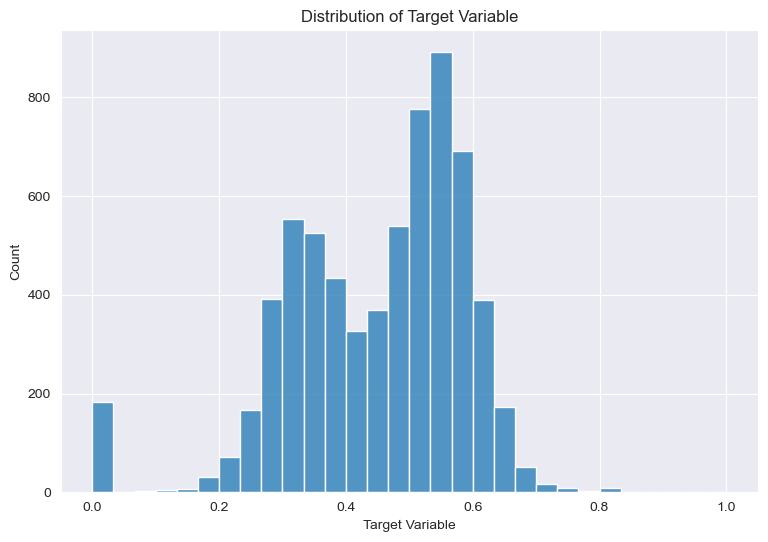

In [106]:
plot_distribution(y_g1)

In [107]:
len(y_g1.unique())

6289

In [108]:
# Statistical summary of the target variable, which contains the count,
# mean, standard deviation, minimum and maximum values and the percentiles.
y_g1.describe()

count    6620.000000
mean        0.449405
std         0.139392
min         0.000000
25%         0.348935
50%         0.482790
75%         0.554830
max         1.000000
Name: g1_21, dtype: float64

We will extract the features with the highest correlation with the target variable and use them to train the model. To do so, we will use Mutual Information Regression.

In [109]:
def get_top_n_features(X: pd.DataFrame, y: pd.Series, top_n: int)->Tuple[pd.DataFrame, pd.Series]:

    # raise error if top_n is not between 1 and the length of the features
    if not 1 <= top_n <= X.shape[1]:
        raise ValueError('top_n must be between 1 and the number of features')
    
    # create a dataframe to store the mutual information scores
    mi_scores = pd.DataFrame(mutual_info_regression(X, y), index=X.columns, columns=['MI Score'])

    # sort the dataframe by the mutual information scores
    mi_scores = mi_scores.sort_values(by='MI Score', ascending=False)

    X_top_n = X[mi_scores.index[:top_n]]

    return X_top_n, y

In [110]:
X, y = get_top_n_features(X_g1, y_g1, 10)

Important steps in the data preparation is to split the dataset into train and test set, and then to scale them.

In [111]:
X_g1_train, X_g1_test, y_g1_train, y_g1_test = train_test_split(X_g1, 
                                                                y_g1, 
                                                                test_size=0.2, 
                                                                random_state=42)

Scaling would be done using StandardScaler.

In [112]:
scaler_X_g1 = StandardScaler()
X_g1_train = scaler_X_g1.fit_transform(X_g1_train)
X_g1_test = scaler_X_g1.transform(X_g1_test)

scaler_y_g1 = StandardScaler()
y_g1_train = scaler_y_g1.fit_transform(y_g1_train.values.reshape(-1, 1))
y_g1_test = scaler_y_g1.transform(y_g1_test.values.reshape(-1, 1))

# reshape the target variable to 1D numpy array
y_g1_train = y_g1_train.ravel()
y_g1_test = y_g1_test.ravel()

In [113]:
def evaluate_model(y_true: np.ndarray, y_pred: np.ndarray, model_name: str)->None:
    print('MSE: ', mean_squared_error(y_true, y_pred))
    print('R2 score: ', r2_score(y_true, y_pred))

    plt.figure(figsize=(10, 5))
    sns.set_style('darkgrid')
    sns.scatterplot(x=y_true, y=y_pred)
    sns.lineplot(x=y_true, y=y_true, color='red')
    plt.title(f'{model_name} predictions')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.show()

We would start with base model, which would be Linear Regression.

MSE:  0.24340376199376604
R2 score:  0.7368747552808135


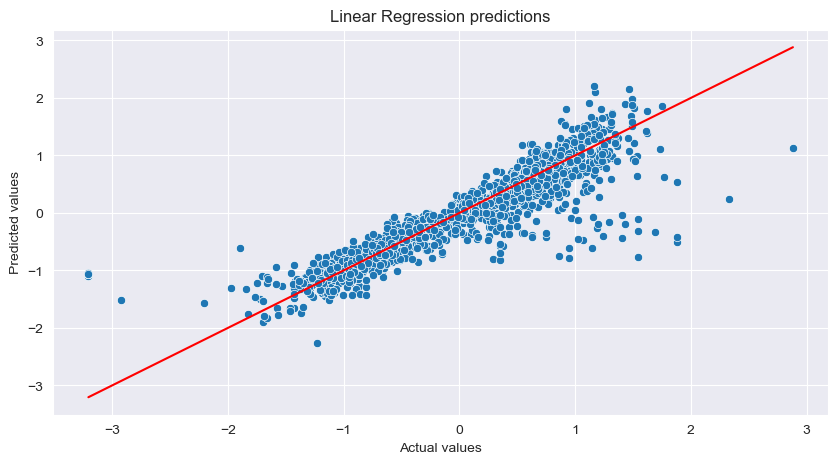

In [114]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_g1_train, y_g1_train)
y_g1_pred = lr.predict(X_g1_test)

evaluate_model(y_g1_test, y_g1_pred, 'Linear Regression')

The linear regression model is performing poorly, with the R2 score of 0.74. 

We would try to improve the model using Random Forest Regressor and XGBoost Regressor.

MSE:  0.008959047597760603
R2 score:  0.9903150568738047


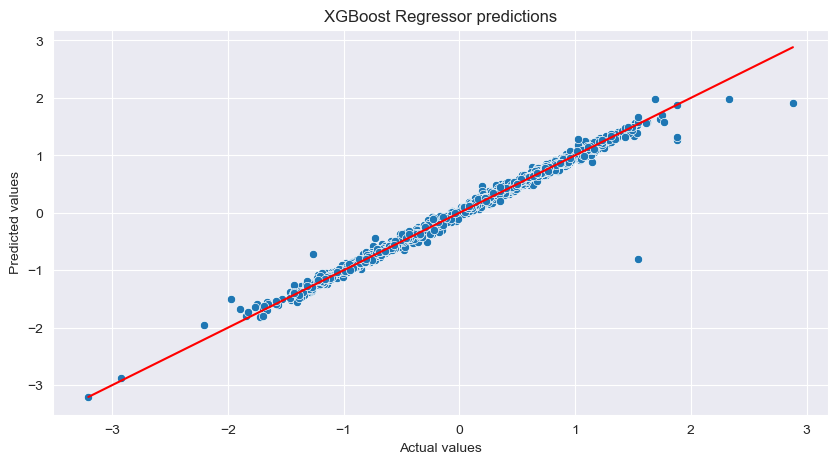

In [115]:
xgb = XGBRegressor()
xgb.fit(X_g1_train, y_g1_train)
y_g1_pred = xgb.predict(X_g1_test)

evaluate_model(y_g1_test, y_g1_pred, 'XGBoost Regressor')

MSE:  0.006128311235361912
R2 score:  0.9933751500785709


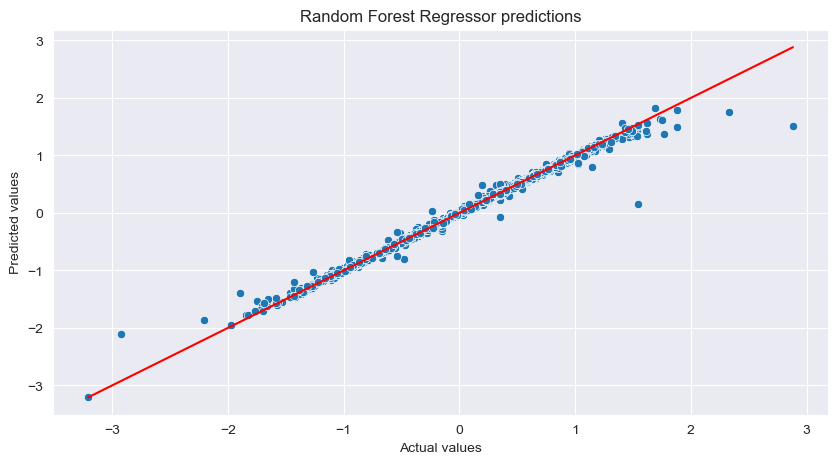

In [116]:
rf = RandomForestRegressor()
rf.fit(X_g1_train, y_g1_train)
y_g1_pred = rf.predict(X_g1_test)

evaluate_model(y_g1_test, y_g1_pred, 'Random Forest Regressor')

The results are much better, with the R2 score of 0.99 for both models.

#### The second group of clients

Column names starting with “g2_”:
* contain information about the second customer group,
* variables g2_1 until g2_20 were known before the campaign was run,
* variable g2_21 was recorded after the campaign was run

We would repeat the same steps as for the first group of clients. The same methods would be used to prepare the data and to train the model.

In [117]:
X_g2 = df.iloc[:, 21:41]
X_g2.head()

,g2_1,g2_2,g2_3,g2_4,g2_5,g2_6,g2_7,g2_8,g2_9,g2_10,g2_11,g2_12,g2_13,g2_14,g2_15,g2_16,g2_17,g2_18,g2_19,g2_20
0,1.83,6,0,6,7,4,0,0,1,4,-1,3,2.888736,2.616855,5.552000,0.728000,0.160000,0.002994,0.002953,0.586149
1,2.80,34,14,48,10,25,16,16,24,9,-8,1,4.065822,4.042015,6.369385,1.511704,1.783791,0.784882,0.033373,0.498949
2,1.30,11,18,29,2,13,3,16,1,10,15,25,4.918483,4.050389,10.029408,2.489174,0.204741,0.022247,0.042004,0.567984
3,4.50,5,3,8,17,5,9,7,16,-4,-9,-13,1.964163,2.278147,3.369489,0.665585,2.163561,0.043937,0.010358,0.273886
4,3.00,29,23,52,8,31,22,21,23,9,-2,7,4.527831,4.215284,4.494986,1.419174,1.144728,0.364776,0.008148,0.347568


In [118]:
y_g2 = df.iloc[:, 41]
y_g2.head()

0    3.50
1    3.25
2    5.00
3    3.60
4    3.40
Name: g2_21, dtype: float64

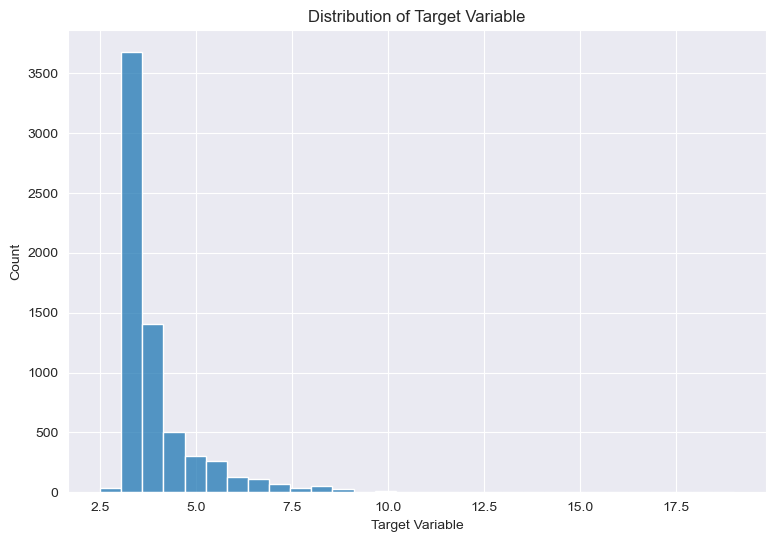

In [119]:
plot_distribution(y_g2)

As we can see, the target variable is not normally distributed.

It looks like this variable is desctibed by discrete values.

In [120]:
# Number of unique values in the target variable
len(y_g2.unique())

52

We have only 52 unique values for the target variable and 6620 rows.

Even though we would try to predict the target variable using regression models.

In [121]:
# statistical summary of the labels
y_g2.describe()

count    6620.000000
mean        3.899359
std         1.093160
min         2.500000
25%         3.250000
50%         3.500000
75%         4.000000
max        19.000000
Name: g2_21, dtype: float64

In [122]:
# choose the top 10 features
X_g2, y_g2 = get_top_n_features(X_g2, y_g2, 10)

In [123]:
# split the data into train and test sets
X_g2_train, X_g2_test, y_g2_train, y_g2_test = train_test_split(X_g2, y_g2, test_size=0.2, random_state=42)

# scale the data
scaler_X_g2 = StandardScaler()
X_g2_train = scaler_X_g2.fit_transform(X_g2_train)
X_g2_test = scaler_X_g2.transform(X_g2_test)

scaler_y_g2 = StandardScaler()
y_g2_train = scaler_y_g2.fit_transform(y_g2_train.values.reshape(-1, 1))
y_g2_test = scaler_y_g2.transform(y_g2_test.values.reshape(-1, 1))

# reshape the target variable to 1D numpy array
y_g2_train = y_g2_train.ravel()
y_g2_test = y_g2_test.ravel()

MSE:  0.25340269661520354
R2 score:  0.7503035162773094


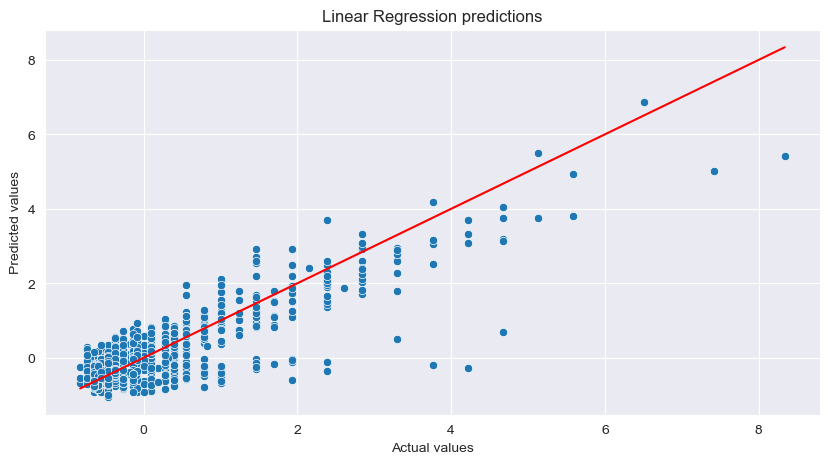

In [124]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_g2_train, y_g2_train)
y_g2_pred = lr.predict(X_g2_test)

evaluate_model(y_g2_test, y_g2_pred, 'Linear Regression')

MSE:  0.07838456652068142
R2 score:  0.9227618691522353


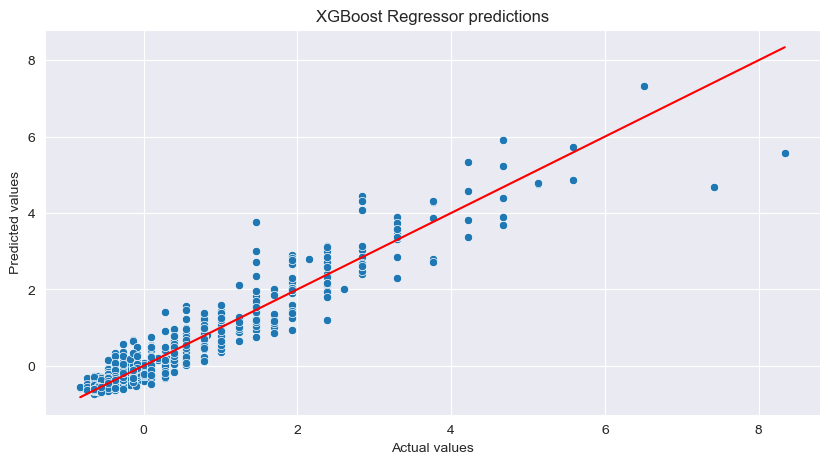

In [125]:
xgb = XGBRegressor()
xgb.fit(X_g2_train, y_g2_train)
y_g2_pred = xgb.predict(X_g2_test)

evaluate_model(y_g2_test, y_g2_pred, 'XGBoost Regressor')

MSE:  0.07879032248273354
R2 score:  0.9223620476888996


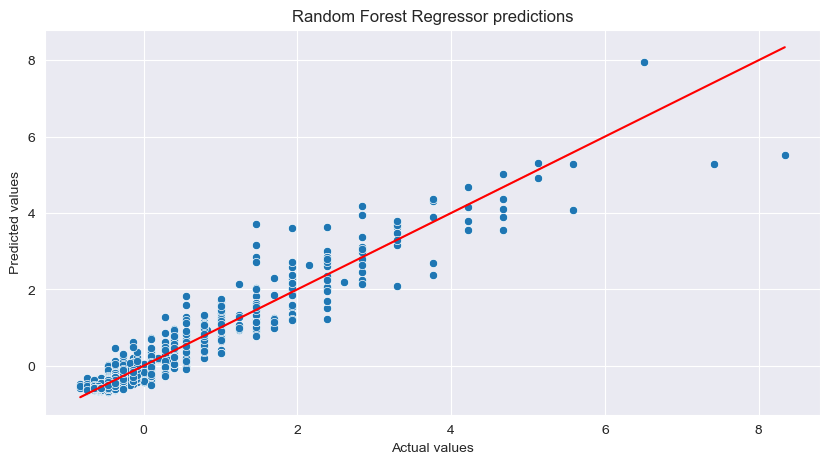

In [126]:
rf = RandomForestRegressor()
rf.fit(X_g2_train, y_g2_train)
y_g2_pred = rf.predict(X_g2_test)

evaluate_model(y_g2_test, y_g2_pred, 'Random Forest Regressor')

The results are much worse than for the first group of clients, with the maximum R2 score of 0.91.

#### Comparison of two groups of clients

Column names starting with “c_”:
* contain features representing some comparison of the two groups,
* variables c_1 until c_27 were known before the campaign was run,
* variable c_28 was recorded after the campaign was run.


In [127]:
X_c = df.iloc[:, 42:69]
X_c.head()

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,...,c_18,c_19,c_20,c_21,c_22,c_23,c_24,c_25,c_26,c_27
0,1.97,-1,7,6,0,0,0,1,3.223605,1,...,-6,-5,-0.383704,-0.065449,0.584000,0.488000,0,-3.232000,-1.944000,-0.007944
1,1.85,2,1,3,0,0,0,0,1.541039,10,...,-13,-9,-0.346839,-0.159744,-0.947614,0.463540,0,-5.342174,-1.321355,0.181064
2,1.70,-5,10,5,0,0,0,1,2.049024,-11,...,-18,-36,-2.673934,-1.592303,0.525305,-0.467169,0,-6.566521,-4.176403,-0.040277
3,1.98,-1,3,2,0,0,0,0,2.284503,5,...,1,9,0.616027,0.404945,-1.506923,0.741964,0,-2.438120,-0.787132,-0.012101
4,1.80,-3,2,-1,1,0,0,0,2.648418,0,...,-18,-8,-1.057214,-1.159294,0.751012,-0.182052,0,-1.259728,0.059574,0.042613


In [128]:
y_c = df.iloc[:, 69]
y_c.head()

0    1.76
1    1.85
2    2.05
3    1.82
4    1.99
Name: c_28, dtype: float64

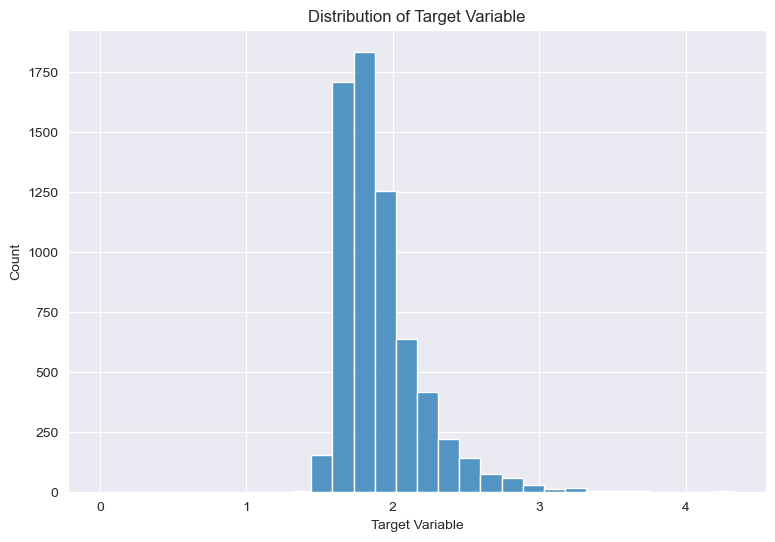

In [129]:
plot_distribution(y_c)

In [130]:
len(y_c.unique())

191

In [131]:
# statistical summary of the labels
y_c.describe()

count    6620.000000
mean        1.917134
std         0.302175
min         0.000000
25%         1.710000
50%         1.850000
75%         2.020000
max         4.330000
Name: c_28, dtype: float64

In [132]:
X_c, y_c = get_top_n_features(X_c, y_c, 10)

In [133]:
# split the data into train and test sets
X_c_train, X_c_test, y_c_train, y_c_test = train_test_split(X_c, y_c, 
                                                            test_size=0.2, 
                                                            random_state=42)

# scale the data
scaler_X_c = StandardScaler()
X_c_train = scaler_X_c.fit_transform(X_c_train)
X_c_test = scaler_X_c.transform(X_c_test)

scaler_y_c = StandardScaler()
y_c_train = scaler_y_c.fit_transform(y_c_train.values.reshape(-1, 1))
y_c_test = scaler_y_c.transform(y_c_test.values.reshape(-1, 1))

# reshape the target variable to 1D numpy array
y_c_train = y_c_train.ravel()
y_c_test = y_c_test.ravel()

MSE:  0.194089974740323
R2 score:  0.8014528861352178


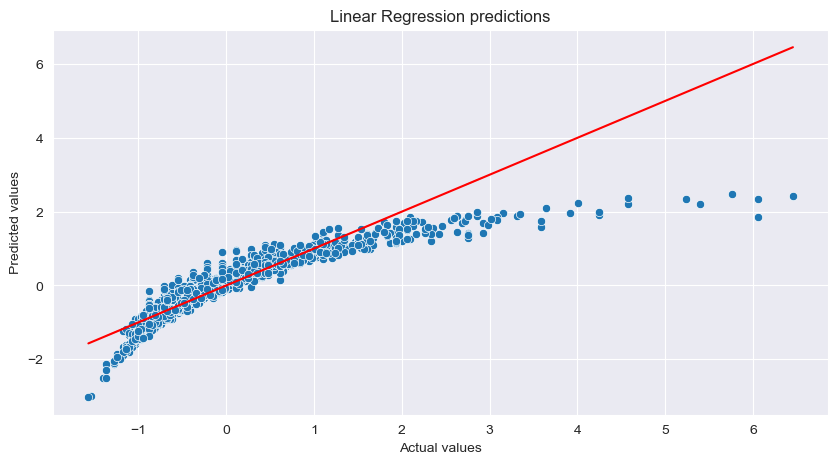

In [134]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_c_train, y_c_train)
y_c_pred = lr.predict(X_c_test)

evaluate_model(y_c_test, y_c_pred, 'Linear Regression')

MSE:  0.028410550013146418
R2 score:  0.9709370217809123


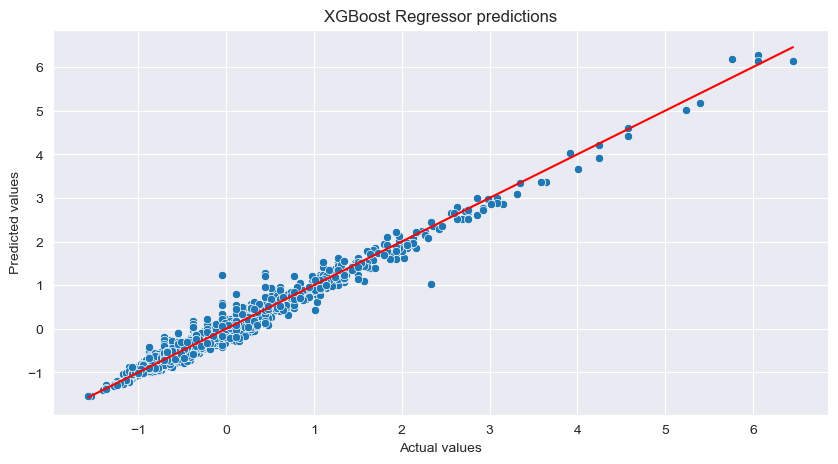

In [135]:
xgb = XGBRegressor()
xgb.fit(X_c_train, y_c_train)
y_c_pred = xgb.predict(X_c_test)

evaluate_model(y_c_test, y_c_pred, 'XGBoost Regressor')

MSE:  0.028505493016035676
R2 score:  0.9708398984790493


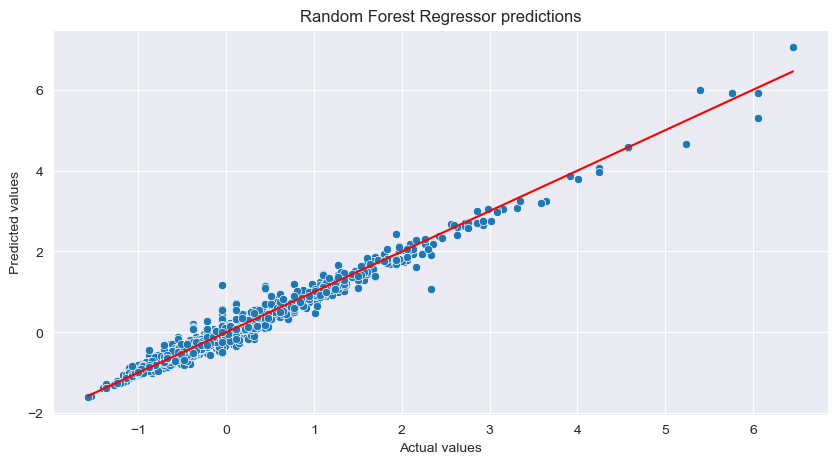

In [136]:
# random forest regressor
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_c_train, y_c_train)
y_c_pred = rf.predict(X_c_test)

evaluate_model(y_c_test, y_c_pred, 'Random Forest Regressor')

## Classification task: which customers group was profitable for the company?

We will be using the same data as for the regression task. This time, we will try to predict the target variable which is categorical variable with three possible values:
* 0: none of the two groups of clients was profitable,
* 1: first group was the most profitable,
* 2: second group was the most profitable.

In [137]:
# The last column is the target variable in classification problem
y = df.iloc[:, -1].values

In [138]:
# This time we want to plot the countplot
def plot_countplot(y: np.ndarray)->None:
    plt.figure(figsize=(10,6))
    sns.countplot(x=y, palette='Greens_d')
    plt.title('Countplot of the target variable')
    plt.xlabel('Target variable')
    plt.ylabel('Count')
    plt.show()

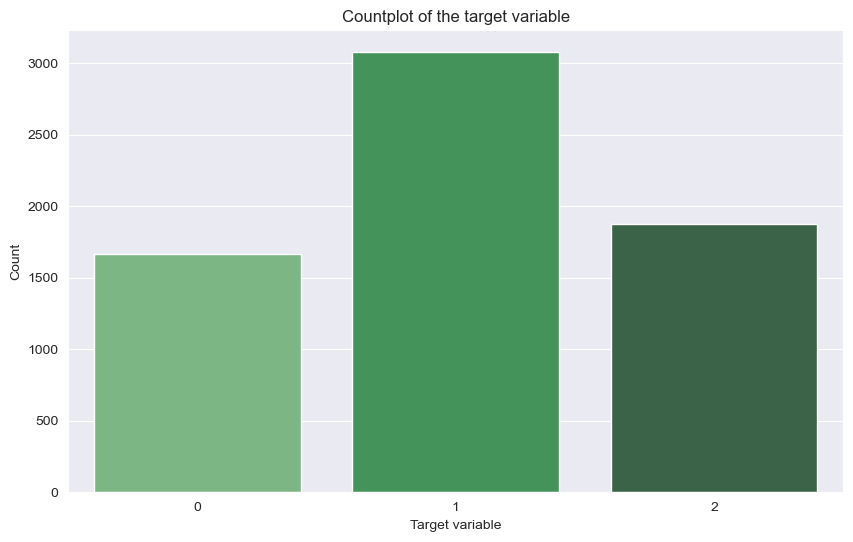

In [139]:
plot_countplot(y)

In [140]:
count = Counter(y)
print('Exact number of samples in each class and their percentage of the total number of samples:')
for k,v in count.items():
    per = v / len(y) * 100
    print(f'Class= {k}, n={v} ({per:.2f}%)')

Exact number of samples in each class and their percentage of the total number of samples:
Class= 2, n=1877 (28.35%)
Class= 1, n=3076 (46.47%)
Class= 0, n=1667 (25.18%)


As we can see, the target variable is not evenly distributed. The most common value is 1, which means that the first group of clients was the most profitable.

The second information we can see is that most of the time the campaigns were profitable.

In [141]:
# The percentage of successful campaigns in which
# the first group of clients was more profitable

per2 = count.get(1) / (count.get(2) + count.get(1)) * 100
print(f'Percentage of successful campaigns in which the first group of clients was more profitable: {per2:.2f}%')

Percentage of successful campaigns in which the first group of clients was more profitable: 62.10%


### **Question**: Are we able to predict which group will be profitable for the company only based on the information known before the campaign was run?

In [142]:
# Concatenate the numerical features fro
X = pd.concat([X_g1, X_g2, X_c], axis=1)
X.head()

,g1_1,g1_2,g1_3,g1_4,g1_5,g1_6,g1_7,g1_8,g1_9,g1_10,...,c_1,c_19,c_12,c_21,c_18,c_6,c_20,c_2,c_11,c_3
0,4.50,1,3,4,5,1,1,4,6,0,...,1.97,-5,-2,-0.065449,-6,0,-0.383704,-1,-3,7
1,2.20,24,22,46,10,24,28,18,22,-4,...,1.85,-9,-2,-0.159744,-13,0,-0.346839,2,-12,1
2,12.00,7,4,11,18,8,11,2,10,-3,...,1.70,-36,-18,-1.592303,-18,0,-2.673934,-5,-7,10
3,1.91,8,5,13,14,6,7,6,9,-1,...,1.98,9,5,0.404945,1,0,0.616027,-1,0,3
4,2.50,23,16,39,14,33,25,18,27,8,...,1.80,-8,-13,-1.159294,-18,0,-1.057214,-3,-13,2


Mutual information is a measure of the mutual dependence between the target variable and the feature. It is equal to zero if the two variables are independent, is non-negative, and the higher the value, the higher the dependence.and higher values mean higher dependence. Mutual information is calculated for both categorical and numerical features.

In [143]:
def plot_mutual_inf_chart(X: pd.DataFrame, y: np.ndarray)->None:
    mutual_info = mutual_info_classif(X, y)
    mutual_info = pd.Series(mutual_info)
    mutual_info.index = X.columns
    mutual_info = mutual_info.sort_values(ascending=False)

    plt.figure(figsize=(10,6))
    sns.barplot(x=mutual_info.index, y=mutual_info.values, palette='Greens_d')
    plt.title('Mutual Information with respect to the target variable')
    plt.ylabel('Mutual Information')
    plt.xlabel('Features')
    plt.xticks(rotation=90)
    plt.show()

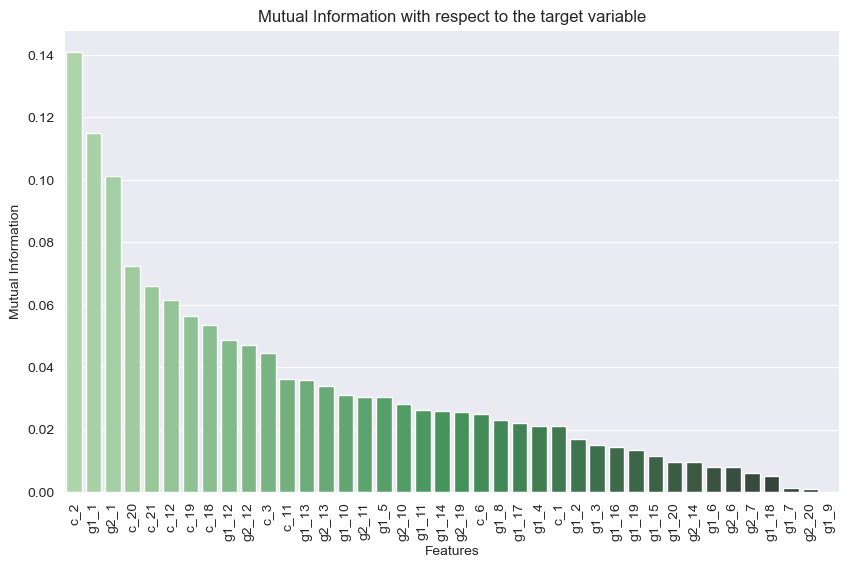

In [144]:
plot_mutual_inf_chart(X, y)

In [145]:
# We will choose the top 10 features
X,y = get_top_n_features(X, y, 10)

In [146]:
def plot_correlation_matrix(X: pd.DataFrame)->None:
    plt.figure(figsize=(12,8))
    sns.heatmap(X.corr(), annot=True, cmap='Greens')
    plt.title('Correlation Matrix')
    plt.show()

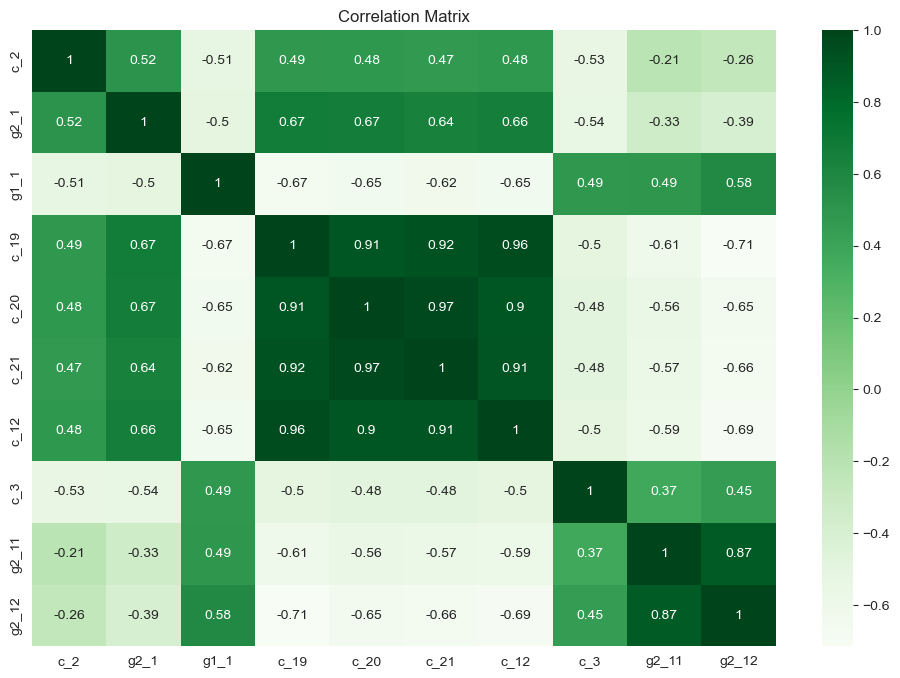

In [147]:
plot_correlation_matrix(X)

In [148]:
# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

# scale the data
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

In [149]:
def evaluate_classification_model(y_true: np.ndarray, y_pred: np.ndarray, model_name: str)->pd.DataFrame:
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    df = pd.DataFrame(data=[accuracy, precision, recall, f1],
                      index=['accuracy', 'precision', 'recall', 'f1'],
                      columns=[model_name])
    return df

In [150]:
def plot_confusion_matrix(clf, X: np.ndarray, y: np.ndarray)->None:
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(10,6))
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='g')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [151]:
# XGBoost Classifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

xgb_metrics = evaluate_classification_model(y_test, y_pred, 'XGBoost Classifier')
xgb_metrics.head()

,XGBoost Classifier
accuracy,0.564199
precision,0.533726
recall,0.564199
f1,0.542619


In [152]:
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)

ada_metrics = evaluate_classification_model(y_test, y_pred, 'ADA Boost Classifier')
ada_metrics.head()

,ADA Boost Classifier
accuracy,0.588369
precision,0.539164
recall,0.588369
f1,0.542236


In [153]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

gbc_metrics = evaluate_classification_model(y_test, y_pred, 'Gradient Boosting Classifier')
gbc_metrics.head()

,Gradient Boosting Classifier
accuracy,0.595166
precision,0.557309
recall,0.595166
f1,0.559739


In [154]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

rf_metrics = evaluate_classification_model(y_test, y_pred, 'Random Forest Classifier')
rf_metrics.head()

,Random Forest Classifier
accuracy,0.572508
precision,0.538390
recall,0.572508
f1,0.546951


In [155]:
# Extra Trees Classifier
etc = ExtraTreesClassifier()
etc.fit(X_train, y_train)
y_pred = etc.predict(X_test)

etc_metrics = evaluate_classification_model(y_test, y_pred, 'Extra Trees Classifier')
etc_metrics.head()

,Extra Trees Classifier
accuracy,0.564199
precision,0.530555
recall,0.564199
f1,0.537950


In [156]:
# Bagging Classifier
bc = BaggingClassifier()
bc.fit(X_train, y_train)
y_pred = bc.predict(X_test)

bc_metrics = evaluate_classification_model(y_test, y_pred, 'Bagging Classifier')
bc_metrics.head()

,Bagging Classifier
accuracy,0.539275
precision,0.526669
recall,0.539275
f1,0.530576


In [157]:
# Voting Classifier
vc = VotingClassifier(estimators=[('xgb', xgb), ('ada', ada), 
                                  ('gbc', gbc), ('rf', rf), 
                                  ('etc', etc), ('bc', bc)])
vc.fit(X_train, y_train)
y_pred = vc.predict(X_test)

vc_metrics = evaluate_classification_model(y_test, y_pred, 'Voting Classifier')
vc_metrics.head()

,Voting Classifier
accuracy,0.577039
precision,0.540189
recall,0.577039
f1,0.548135


We can also use deep learning models to predict the target variable. To do so we have to encode the categorical features. We will use OneHotEncoder for this purpose.

In [158]:
# one-hot encode the y_train and y_test variables to use them in the neural network
enc = OneHotEncoder()
y_train_nn = enc.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test_nn = enc.transform(y_test.reshape(-1, 1)).toarray()


In [159]:
# neural network using keras
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               1408      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 9,859
Trainable params: 9,859
Non-trainable params: 0
_________________________________________________________________


In [160]:
# early stopping
early_stop = EarlyStopping(monitor='val_loss',
                           mode='min',
                           verbose=1,
                           patience=10)

model.fit(x=X_train,
            y=y_train_nn,
            epochs=500,
            batch_size=128,
            validation_data=(X_test, y_test_nn),
            callbacks=[early_stop])

Epoch 1/500
42/42 [==============================] - 1s 15ms/step - loss: 0.9742 - accuracy: 0.5359 - val_loss: 0.9401 - val_accuracy: 0.5695
Epoch 2/500
42/42 [==============================] - 0s 7ms/step - loss: 0.9291 - accuracy: 0.5765 - val_loss: 0.9245 - val_accuracy: 0.5808
Epoch 3/500
42/42 [==============================] - 0s 8ms/step - loss: 0.9205 - accuracy: 0.5793 - val_loss: 0.9209 - val_accuracy: 0.5846
Epoch 4/500
42/42 [==============================] - 0s 9ms/step - loss: 0.9175 - accuracy: 0.5831 - val_loss: 0.9208 - val_accuracy: 0.5823
Epoch 5/500
42/42 [==============================] - 0s 8ms/step - loss: 0.9145 - accuracy: 0.5887 - val_loss: 0.9219 - val_accuracy: 0.5846
Epoch 6/500
42/42 [==============================] - 0s 7ms/step - loss: 0.9128 - accuracy: 0.5857 - val_loss: 0.9184 - val_accuracy: 0.5838
Epoch 7/500
42/42 [==============================] - 0s 8ms/step - loss: 0.9091 - accuracy: 0.5855 - val_loss: 0.9177 - val_accuracy: 0.5853
Epoch 8/500


In [161]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test_nn, axis=1)

nn_metrics = evaluate_classification_model(y_test, y_pred, 'Neural Network')
nn_metrics.head()

42/42 [==============================] - 1s 12ms/step


,Neural Network
accuracy,0.589124
precision,0.546476
recall,0.589124
f1,0.538227


In [162]:
# function to aggregate the metrics of all models in one dataframe
def aggregate_metrics(*args)->pd.DataFrame:
    df = pd.concat(args, axis=1)
    return df

def highlight_max(s):
    is_max = s == s.max()
    is_min = s == s.min()
    return ['background-color: green' if v else 'background-color: red' if x else '' for v,x in zip(is_max, is_min)]

In [163]:
def plot_multiclass_roc(clf, X_test:np.ndarray, y_test: np.ndarray, classifier_name: str)->None:
    y_score = clf.predict_proba(X_test)
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
    n_classes = y_test_bin.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot of a ROC curve for a specific class on one plot
    plt.figure(figsize=(10, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve for class {i} (area = {roc_auc[i]:0.2f})')

    # micro-average ROC curve plot
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.plot(fpr["micro"], tpr["micro"], label=f'ROC curve for micro-average (area = {roc_auc["micro"]:0.2f})', linestyle='--', linewidth=2)

    # macro-average ROC curve plot
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.plot(fpr["macro"], tpr["macro"], 
             label=f'ROC curve for macro-average (area = {roc_auc["macro"]:0.2f})', 
             linestyle='--', linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {classifier_name}')
    plt.legend(loc="lower right")
    plt.show()

### Answer

In [164]:
aggregate_df = aggregate_metrics(xgb_metrics, ada_metrics, 
                                 gbc_metrics, rf_metrics, 
                                 etc_metrics, bc_metrics, 
                                 vc_metrics, nn_metrics)

aggregate_df.style.apply(highlight_max, axis=1)

,XGBoost Classifier,ADA Boost Classifier,Gradient Boosting Classifier,Random Forest Classifier,Extra Trees Classifier,Bagging Classifier,Voting Classifier,Neural Network
accuracy,0.564199,0.588369,0.595166,0.572508,0.564199,0.539275,0.577039,0.589124
precision,0.533726,0.539164,0.557309,0.538390,0.530555,0.526669,0.540189,0.546476
recall,0.564199,0.588369,0.595166,0.572508,0.564199,0.539275,0.577039,0.589124
f1,0.542619,0.542236,0.559739,0.546951,0.537950,0.530576,0.548135,0.538227


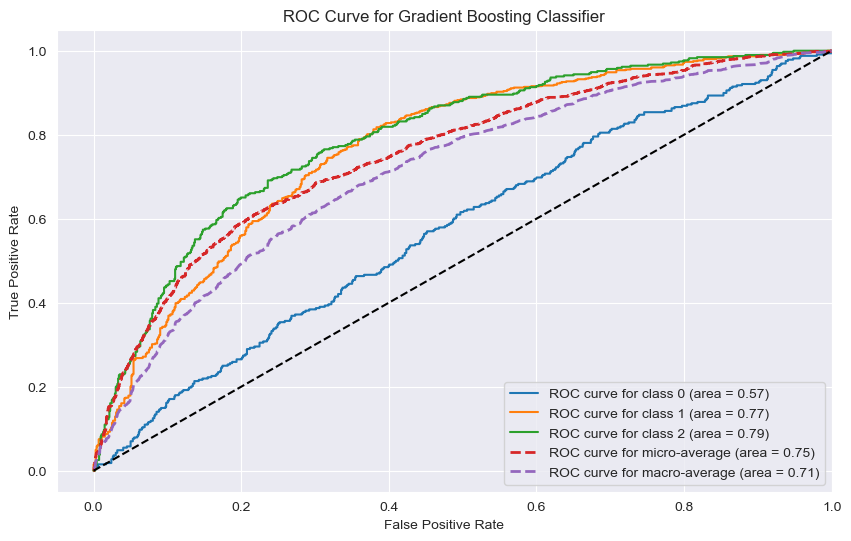

In [165]:
plot_multiclass_roc(gbc, X_test, y_test, 'Gradient Boosting Classifier')

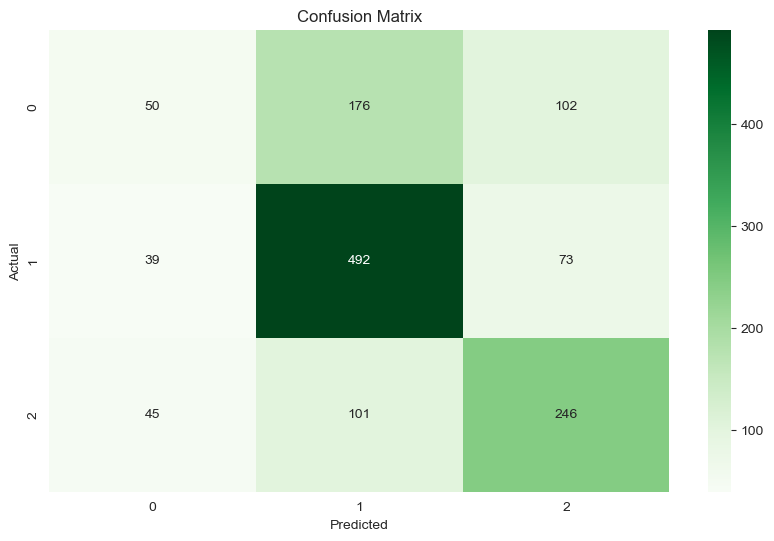

In [166]:
plot_confusion_matrix(gbc, X_test, y_test)

In [184]:
# Classification report gives us the precision, recall, f1-score and support for each class

y_pred = gbc.predict(X_test)

print("Classification Report for Gradient Boosting Classifier")
print(classification_report(y_test, y_pred))

Classification Report for Gradient Boosting Classifier
              precision    recall  f1-score   support

           0       0.37      0.15      0.22       328
           1       0.64      0.81      0.72       604
           2       0.58      0.63      0.61       392

    accuracy                           0.60      1324
   macro avg       0.53      0.53      0.51      1324
weighted avg       0.56      0.60      0.56      1324



We can see that precision, recall, f1-score and accuracy are the lowest for the class 0, which means that the model is not able to predict well when none of the groups is profitable. The model is performing much better for the classes 1 and 2, which means that the model is able to predict well which group is more profitable, when both of them are profitable.

Above table shows the results of the models we have trained. The ROC curve with AUC score and Confusion matrix can also help us to evaluate the models.

The accuracy of the best model is around 0.59 which is not very good but it is for sure better than random guessing. 

The F1 score is 0.56 which is also not very good. 

Presented models without a doubt can be improved. To do so, we would need far more data. Ideally, we would have evenly distributed classes. 

One possible solution to test campaign is to use A/B testing. 

A/B testing campaigns test two versions of the same campaign on a small sample of the target audience. The version that performs better is then sent to the rest of the target audience.

Few of the ways to evaluate the campaign are:
* return on investment (ROI),
* return on ad spend (ROAS),
* cost per acquisition (CPA),
* click-through rate (CTR).

Source: https://demandscience.com/resources/blog/ways-to-measure-campaign-success/

### **Question**: Are we able to predict which group will be profitable for the company only based on the information known **after** the campaign was run?

In [167]:
X_2 = pd.concat([y_g1, y_g2, y_c], 
              axis=1)
X_2.head()

,g1_21,g2_21,c_28
0,0.578205,3.50,1.76
1,0.680013,3.25,1.85
2,0.527707,5.00,2.05
3,0.261785,3.60,1.82
4,0.390180,3.40,1.99


In [168]:
df_concatenate = pd.concat([X_2, 
                            pd.DataFrame(y)],
                            axis=1)
                            
df_concatenate.rename(columns={0: 'label'}, inplace=True)
df_concatenate.head()

,g1_21,g2_21,c_28,label
0,0.578205,3.50,1.76,2
1,0.680013,3.25,1.85,1
2,0.527707,5.00,2.05,2
3,0.261785,3.60,1.82,0
4,0.390180,3.40,1.99,2


In [169]:
# split the data into train and test sets
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y, 
                                                            test_size=0.2, 
                                                            random_state=42)

# scale the data
scaler_X_2 = StandardScaler()
X_2_train = scaler_X_2.fit_transform(X_2_train)
X_2_test = scaler_X_2.transform(X_2_test)

In [170]:
# xgboost classifier
xgb_2 = XGBClassifier()
xgb_2.fit(X_2_train, y_2_train)
y_2_pred = xgb_2.predict(X_2_test)

xgb_metrics_2 = evaluate_classification_model(y_2_test, y_2_pred, 'XGBoost Classifier')
xgb_metrics_2.head()

,XGBoost Classifier
accuracy,0.432024
precision,0.399399
recall,0.432024
f1,0.395626


In [171]:
# random forest classifier
rf_2 = RandomForestClassifier()
rf_2.fit(X_2_train, y_2_train)
y_2_pred = rf_2.predict(X_2_test)

rf_2_metrics = evaluate_classification_model(y_2_test, y_2_pred, 'Random Forest Classifier')
rf_2_metrics.head()

,Random Forest Classifier
accuracy,0.409366
precision,0.395802
recall,0.409366
f1,0.400232


In [172]:
# AdaBoost Classifier
ada_2 = AdaBoostClassifier()
ada_2.fit(X_2_train, y_2_train)
y_2_pred = ada_2.predict(X_2_test)

ada_2_metrics = evaluate_classification_model(y_2_test, y_2_pred, 'ADA Boost Classifier')
ada_2_metrics.head()

,ADA Boost Classifier
accuracy,0.455438
precision,0.459738
recall,0.455438
f1,0.348174


In [173]:
# Gradient Boosting Classifier
gbc_2 = GradientBoostingClassifier()
gbc_2.fit(X_2_train, y_2_train)
y_2_pred = gbc_2.predict(X_2_test)

gbc_2_metrics = evaluate_classification_model(y_2_test, y_2_pred, 'Gradient Boosting Classifier')
gbc_2_metrics.head()

,Gradient Boosting Classifier
accuracy,0.449396
precision,0.395580
recall,0.449396
f1,0.341861


In [174]:
# Extra Trees Classifier
etc_2 = ExtraTreesClassifier()
etc_2.fit(X_2_train, y_2_train)
y_2_pred = etc_2.predict(X_2_test)

etc_2_metrics = evaluate_classification_model(y_2_test, y_2_pred, 'Extra Trees Classifier')
etc_2_metrics.head()

,Extra Trees Classifier
accuracy,0.416163
precision,0.400196
recall,0.416163
f1,0.404887


### Answer

In [175]:
aggregate_df_2 = aggregate_metrics(xgb_metrics_2, ada_2_metrics,
                                   gbc_2_metrics, rf_2_metrics,
                                   etc_2_metrics)

aggregate_df_2.style.apply(highlight_max, axis=1)

,XGBoost Classifier,ADA Boost Classifier,Gradient Boosting Classifier,Random Forest Classifier,Extra Trees Classifier
accuracy,0.432024,0.455438,0.449396,0.409366,0.416163
precision,0.399399,0.459738,0.395580,0.395802,0.400196
recall,0.432024,0.455438,0.449396,0.409366,0.416163
f1,0.395626,0.348174,0.341861,0.400232,0.404887


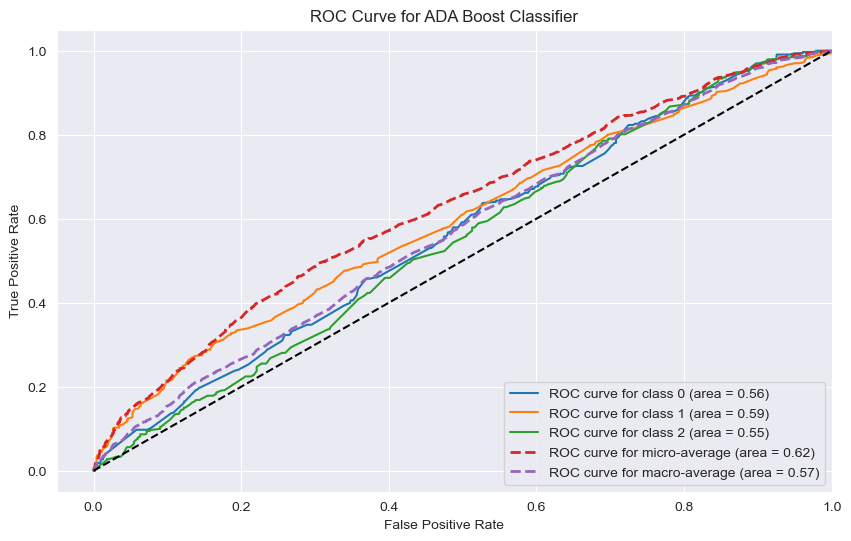

In [176]:
plot_multiclass_roc(ada_2, X_2_test, y_2_test, 'ADA Boost Classifier')

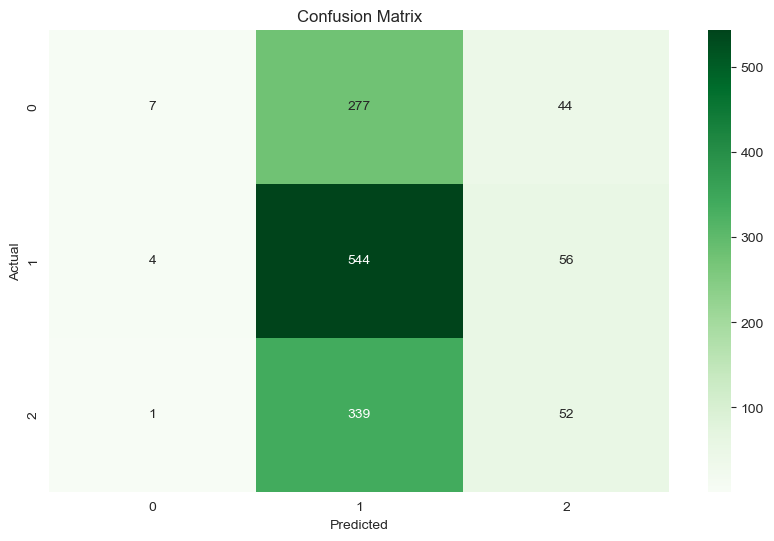

In [177]:
plot_confusion_matrix(ada_2, X_2_test, y_2_test)

As we can see, the predictions are notably worse than for the previous task. 

In the next step we can check the mutual information for the features recorded after the campaign was run and compare it with the mutual information for the features recorded before the campaign was run.

In [178]:
X_3 = df.iloc[:, :-1]
X_3.head()

,g1_1,g1_2,g1_3,g1_4,g1_5,g1_6,g1_7,g1_8,g1_9,g1_10,...,c_19,c_20,c_21,c_22,c_23,c_24,c_25,c_26,c_27,c_28
0,4.50,1,3,4,5,1,1,4,6,0,...,-5,-0.383704,-0.065449,0.584000,0.488000,0,-3.232000,-1.944000,-0.007944,1.76
1,2.20,24,22,46,10,24,28,18,22,-4,...,-9,-0.346839,-0.159744,-0.947614,0.463540,0,-5.342174,-1.321355,0.181064,1.85
2,12.00,7,4,11,18,8,11,2,10,-3,...,-36,-2.673934,-1.592303,0.525305,-0.467169,0,-6.566521,-4.176403,-0.040277,2.05
3,1.91,8,5,13,14,6,7,6,9,-1,...,9,0.616027,0.404945,-1.506923,0.741964,0,-2.438120,-0.787132,-0.012101,1.82
4,2.50,23,16,39,14,33,25,18,27,8,...,-8,-1.057214,-1.159294,0.751012,-0.182052,0,-1.259728,0.059574,0.042613,1.99


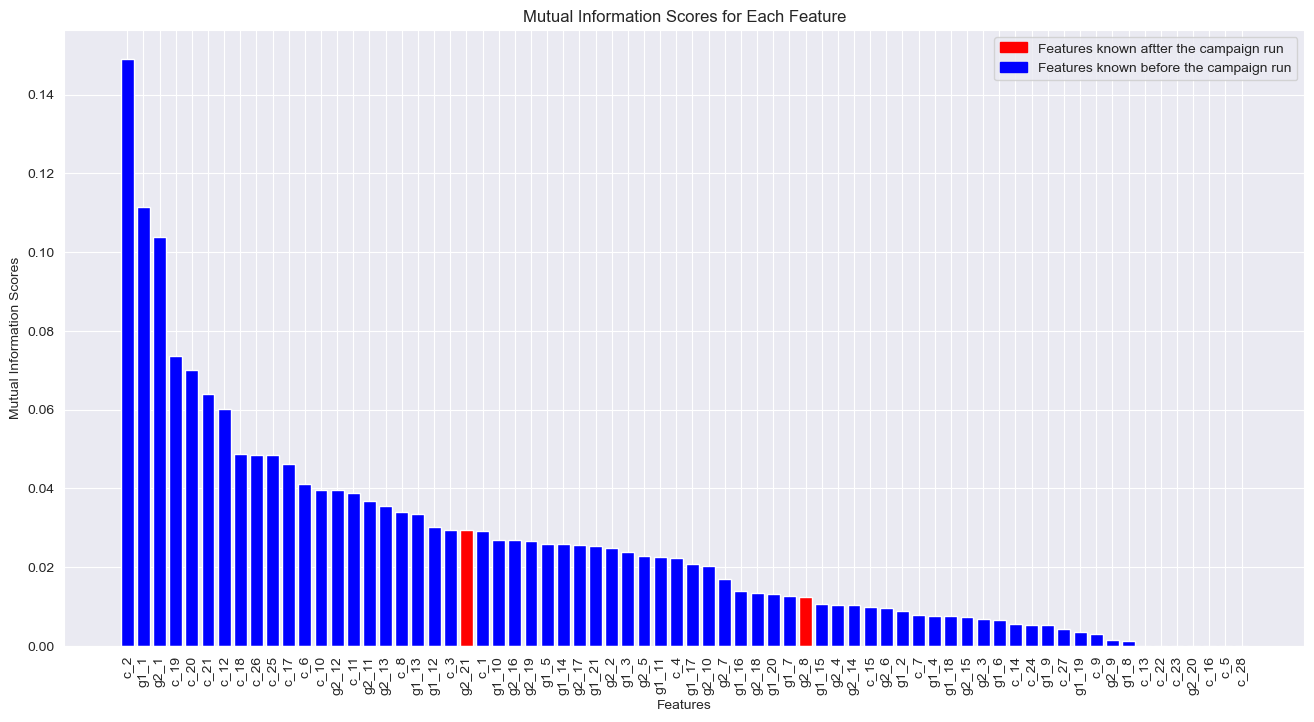

In [179]:
# pot mututal information scores
# g1_21, g2_21 and c_28 are colored in red to distinguish them from the rest of the features

mi_scores = mutual_info_classif(X_3, y, random_state=42)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_3.columns)
mi_scores = mi_scores.sort_values(ascending=False)
mi_scores = mi_scores.to_frame()

# get index of g1_21, g2_21, and c_28
g1_21_index = X_3.columns.get_loc('g1_21')
g2_21_index = X_3.columns.get_loc('g2_21')
c_28_index = X_3.columns.get_loc('c_28')

# plot the mutual information scores for each feature
plt.figure(figsize=(16, 8))
colors = ['red' if (i == g1_21_index + 1 or i == g2_21_index + 1 or i == c_28_index + 1) else 'blue' for i in range(len(mi_scores))]
plt.bar(mi_scores.index, mi_scores['MI Scores'], color=colors)
plt.xticks(rotation=90)
# legend for the red and blue bars
red_patch = mpatches.Patch(color='red', 
                           label='Features known aftter the campaign run')
blue_patch = mpatches.Patch(color='blue', label='Features known before the campaign run')
plt.legend(handles=[red_patch, blue_patch])
plt.xlabel('Features')
plt.ylabel('Mutual Information Scores')
plt.title('Mutual Information Scores for Each Feature')
plt.show()


### Notebook made by Paweł Rajter as a part of recruitment process for Payback.